<a href="https://colab.research.google.com/github/jadhav-rakesh/Time_Series_Forecasting/blob/main/time_series_forecasting_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

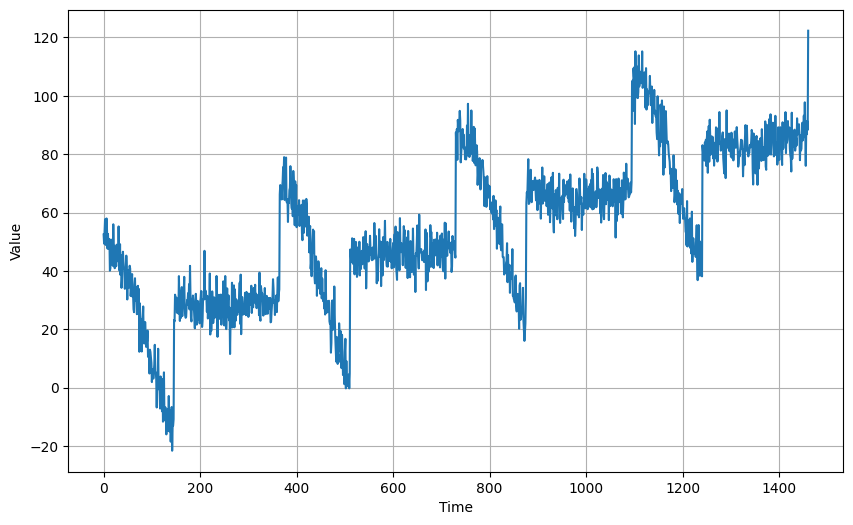

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     30/Unknown 2s 6ms/step - loss: 18.6164 - mae: 19.1134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 18.3124 - mae: 18.8091 - val_loss: 9.7901 - val_mae: 10.2822
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.1784 - mae: 9.6666 - val_loss: 9.0996 - val_mae: 9.5894
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9815 - mae: 9.4665 - val_loss: 8.1763 - val_mae: 8.6630
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9090 - mae: 8.3915 - val_loss: 7.8265 - val_mae: 8.3170
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7078 - mae: 8.1925 - val_loss: 7.6449 - val_mae: 8.1321
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5617 - mae: 8.0480 - val_loss: 7.5305 - val_mae: 8.0161
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4489 - mae: 7.9348 - val_loss: 7.4027 - val_mae: 7.8881
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5654 - mae: 8.0521 - val_loss: 7.4107 - val_mae: 7.9013
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2850 - m

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/30)
)
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 44.0369 - mae: 44.5353 - learning_rate: 1.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.1881 - mae: 33.6863 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.2728 - mae: 21.7685 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1542 - mae: 17.6481 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.0294 - mae: 16.5186 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.6785 - mae: 18.1645 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.6236 - mae: 17.1111 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0443 - mae: 17.5339 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1708 - mae: 15.6626 - learning_rate: 1.8478e-06
Epoch 10/1

(1e-06, 0.001, 0.0, 20.0)

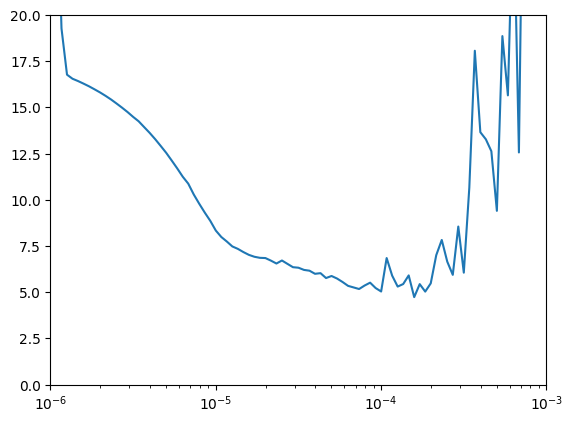

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,
          epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.5836 - mae: 12.0717 - val_loss: 9.4748 - val_mae: 9.9664
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6758 - mae: 9.1629 - val_loss: 8.8802 - val_mae: 9.3644
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9441 - mae: 8.4276 - val_loss: 8.2322 - val_mae: 8.7141
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0276 - mae: 8.5134 - val_loss: 8.1058 - val_mae: 8.5895
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7174 - mae: 8.1984 - val_loss: 8.3230 - val_mae: 8.8108
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3062 - mae: 8.7915 - val_loss: 7.8199 - val_mae: 8.3062
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8333 - mae: 8.3181 - val_loss: 7.8506 - val_mae: 8.3391
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6810 - mae: 8.1628 - val_loss: 7.6750 - val_mae: 8.1658
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
lin_forecast.shape

(461,)

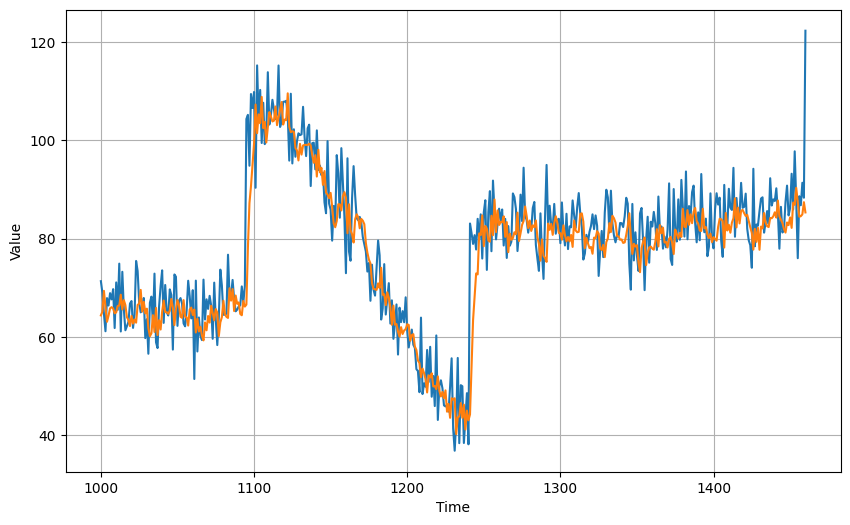

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
mae_metric = keras.metrics.MeanAbsoluteError()
mae_metric.reset_state()
mae_metric.update_state(x_valid, lin_forecast)
mae = mae_metric.result().numpy()
mae

5.0312495

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2891 - mae: 7.7703 - learning_rate: 1.0000e-07
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5710 - mae: 8.0549 - learning_rate: 1.1220e-07
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7025 - mae: 8.1800 - learning_rate: 1.2589e-07
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5003 - mae: 7.9787 - learning_rate: 1.4125e-07
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0125 - mae: 7.4885 - learning_rate: 1.5849e-07
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3481 - mae: 7.8306 - learning_rate: 1.7783e-07
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3899 - mae: 7.8774 - learning_rate: 1.9953e-07
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2382 - mae: 7.7244 - learning_rate: 2.2387e-07
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1076 - mae: 7.5887 - learning_rate: 2.5119e-07
Epoch 10/100
31/31 ━━━━━━━━━

(1e-07, 0.005, 0.0, 30.0)

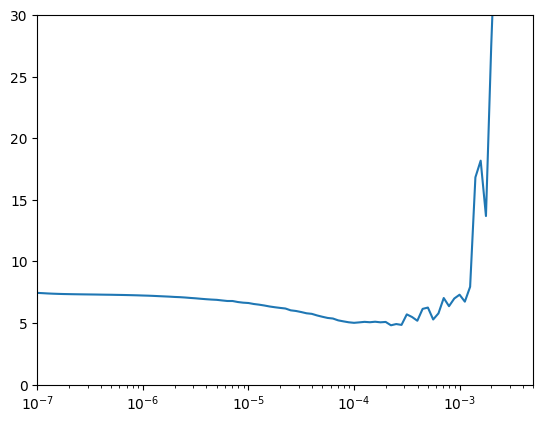

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])


optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.0916 - mae: 65.5916 - val_loss: 118.7785 - val_mae: 119.2785
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63.2029 - mae: 63.7029 - val_loss: 116.9661 - val_mae: 117.4661
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62.9194 - mae: 63.4194 - val_loss: 115.0785 - val_mae: 115.5785
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61.2164 - mae: 61.7164 - val_loss: 113.2100 - val_mae: 113.7100
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 60.9819 - mae: 61.4819 - val_loss: 111.3327 - val_mae: 111.8327
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.3973 - mae: 59.8973 - val_loss: 109.4633 - val_mae: 109.9633
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.6779 - mae: 59.1779 - val_loss: 107.5900 - val_mae: 108.0900
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57.9388 - mae: 58.4388 - val_loss: 105.7072 - val_mae: 106.2072
Epoch 9/500
31

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size
)[:,0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


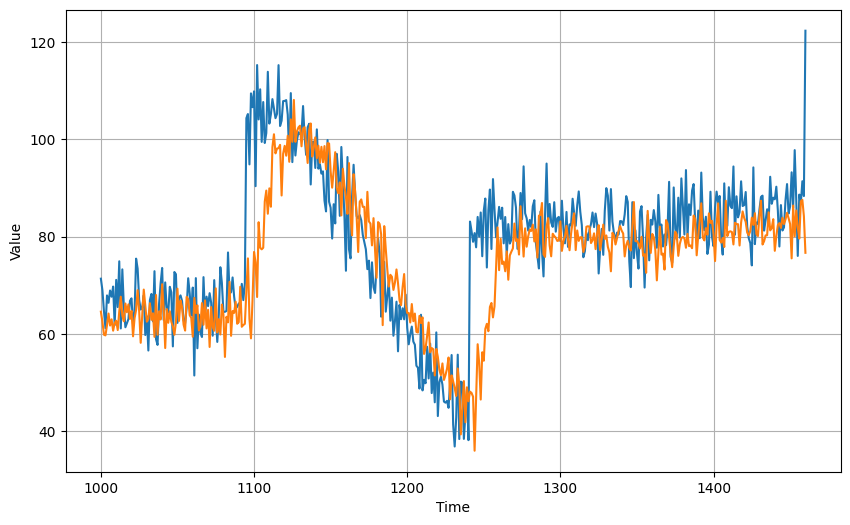

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
mae_metric.reset_state()
mae_metric.update_state(x_valid, dense_forecast)
mae = mae_metric.result().numpy()
mae

7.267756

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 28.6408 - mae: 29.1389 - learning_rate: 1.0000e-07
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 21.3324 - mae: 21.8270 - learning_rate: 1.1220e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 19.1601 - mae: 19.6553 - learning_rate: 1.2589e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 19.4259 - mae: 19.9159 - learning_rate: 1.4125e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 17.0654 - mae: 17.5533 - learning_rate: 1.5849e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 15.2921 - mae: 15.7818 - learning_rate: 1.7783e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 15.2668 - mae: 15.7576 - learning_rate: 1.9953e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 14.8701 - mae: 15.3572 - learning_rate: 2.2387e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 14.9721 - mae: 15.4586 - learning_rate: 2.5119e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━

(1e-07, 0.0001, 0.0, 30.0)

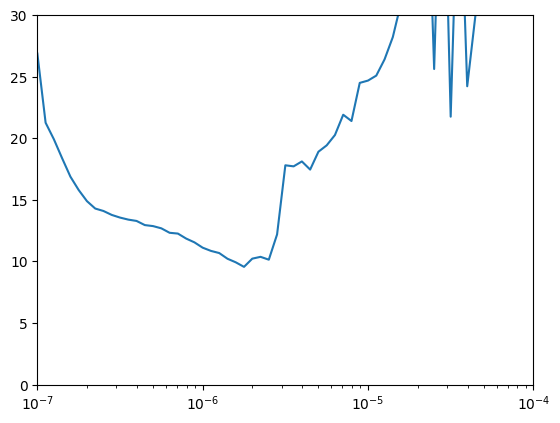

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.keras",
                                                   save_best_only=True)

history = model.fit(train_set, epochs=500,
                    validation_data = valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 47.2788 - mae: 47.7783 - val_loss: 6.6758 - val_mae: 7.1608
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 26.0963 - mae: 26.5882 - val_loss: 18.3231 - val_mae: 18.8223
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 25.2817 - mae: 25.7743 - val_loss: 8.5908 - val_mae: 9.0858
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 26.9649 - mae: 27.4546 - val_loss: 11.6743 - val_mae: 12.1679
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 24.5315 - mae: 25.0208 - val_loss: 7.0180 - val_mae: 7.5012
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 23.3721 - mae: 23.8587 - val_loss: 7.5369 - val_mae: 8.0160
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 23.4757 - mae: 23.9634 - val_loss: 8.3340 - val_mae: 8.8202
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 24.8086 - mae: 25.3031 - val_loss: 6.9384 - val_mae: 7.4263
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/ste

In [ ]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size
)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


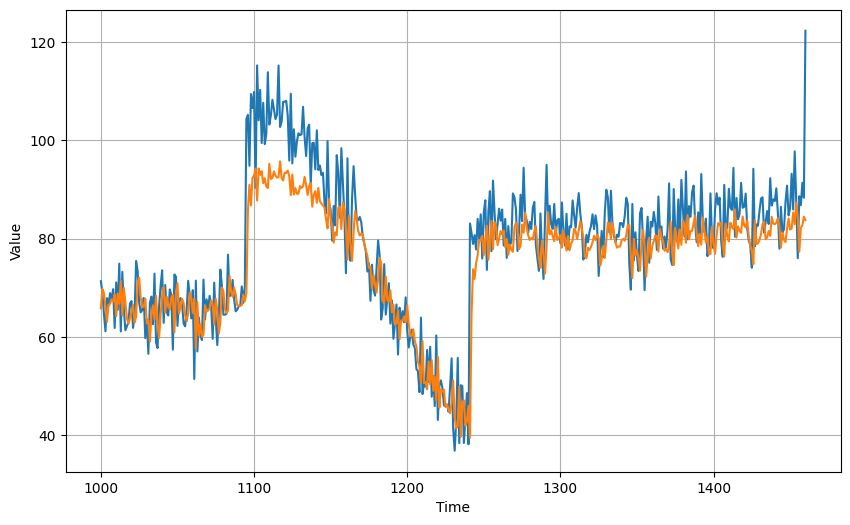

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mae_metric.reset_state()
mae_metric.update_state(x_valid, rnn_forecast)
mae = mae_metric.result().numpy()
mae

5.9627366

In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-7 * 10**(epoch / 30)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 291.4998 - mae: 291.9998 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 240.2671 - mae: 240.7671 - learning_rate: 1.0798e-07
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 158.3898 - mae: 158.8898 - learning_rate: 1.1659e-07
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 78.9332 - mae: 79.4330 - learning_rate: 1.2589e-07
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 27.6207 - mae: 28.1158 - learning_rate: 1.3594e-07
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 35.4627 - mae: 35.9615 - learning_rate: 1.4678e-07
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 26.4929 - mae: 26.9896 - learning_rate: 1.5849e-07
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 23.6219 - mae: 24.1135 - learning_rate: 1.7113e-07
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 21.6366 - mae: 22.1288 - learning_rate: 1.8478e-07
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 20.6398 - mae: 21.1337 - learning_rate: 1.9953e-07
Epoch 11/100
8/8 ━━━━━━━━━

(1e-07, 0.0001, 0.0, 30.0)

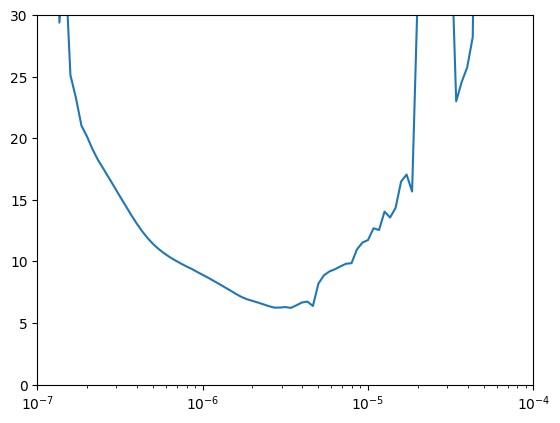

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x * 200.0)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

history = model.fit(train_set, epochs=100,
                    validation_data = valid_set,
                    callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


      7/Unknown 3s 38ms/step - loss: 60.4560 - mae: 60.9557

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 59.6435 - mae: 60.1431 - val_loss: 66.2857 - val_mae: 66.7856
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 36.3799 - mae: 36.8779 - val_loss: 32.6922 - val_mae: 33.1901
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 24.3624 - mae: 24.8570 - val_loss: 24.4145 - val_mae: 24.9107
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 25.5199 - mae: 26.0147 - val_loss: 32.3271 - val_mae: 32.8258
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 21.1289 - mae: 21.6199 - val_loss: 35.4519 - val_mae: 35.9496
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 21.2128 - mae: 21.7032 - val_loss: 27.6290 - val_mae: 28.1243
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 19.9637 - mae: 20.4541 - val_loss: 25.5428 - val_mae: 26.0391
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 19.8779 - mae: 20.3681 - val_loss: 26.1571 - val_mae: 26.6530
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/ste

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


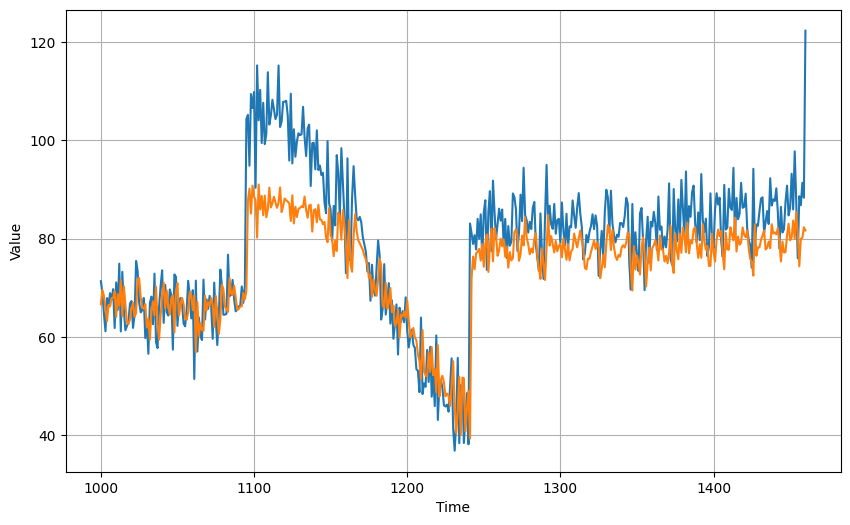

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mae_metric.reset_state()
mae_metric.update_state(x_valid, rnn_forecast)
mae = mae_metric.result().numpy()
mae

7.000774